# Circonus for Data Science

TL;DR Circonus has just got upgraded it's python bindings.
Now you can fetch and process your data with the python Data Science toolchain (Jupyer/numpy/pandas) easily.
Here is how to use them.

## Introduction - Circonus as Telemetry Platform

Circonus is best known as a monitoring solution for IT systems.
However, from it's very beginning it was desigend as a telemetry platform that provides means to collect, store, analyze, and alert on generic telemetry data.

Another core design priciple of Circonus is *API first*.
Everything you can do with the UI, can be automated using direct API access.

This combination is a powerful mix, that allows Circonus to be leveraged as a generic data platform:

- Feed in numeric data from all kinds of sources.
- The data will be stored, indexed and backed-up and for years going forward.
- Act on changes in incoming data using complex alerting rules.
- Visualize and analyze your data with the Circonus UI.
- Access stored data using the Circonus API for further analysis.

We already have a few customers in the IoT domain that leverage our data processing infrastructure for their product.

<hr>

A frequent request we were hearing from many customers is:

> How can I analyze my data with Python?

Data Science has pretty much converged to Python/Jupyer/Numpy toolchain at this point, a seamless integration with this environment unlocks a whole spectrum of advanced data anlaytics capabilities.

### Upgraded Python API Bindings 

For a long time Circonus has provided python API bindings under https://github.com/circonus-labs/python-circonusapi.
These bindings are a thin wrapper, that allow full access to all API features (including the creation of checks and graphs), but are not particularly convenient for fetching and processing data.

These bindings have just gained another module called `circonusdata` which is specifically designed for this purpose.
In the following we will walk you through it's basic usage and give some applications.

### Quick Tour

In [1]:
import json, os
with open(os.path.expanduser("~/work/.circonusrc.json"),"r") as fh:
    config = json.load(fh)
api_token = config['demo']

In [2]:
import circdata

# You need an API token to connect to the API. You can create one under Integrations > API Tokens.
# api_token = "..." 
circ = circdata.CirconusData(api_token)

In [3]:
# Search for some metrics
M = circ.search('d*')

In [4]:
# The resulting object is a list of metrics, that can be indexed, iterated over, etc.
print(M[0])
print(len(M))

CirconusMetric{check_id=246556,name=disk`sda`nread}
63


In [5]:
# Printing the list, gives a table representation of the fetched metrics
print(M)

check_id   type       metric_name
--------------------------------------------------
246556     numeric    disk`sda`nread                                    
246556     numeric    diskstats`sda1`io_ms_weighted                     
246556     numeric    disk`sda`nwritten                                 
246556     numeric    diskstats`sda1`io_ms                              
246556     numeric    disk`sda`reads                                    
246556     numeric    diskstats`sda`io_ms_weighted                      
246556     numeric    diskstats`sda`io_ms                               
246556     numeric    disk`sda`writes                                   
195902     numeric    duration                                          
240232     numeric    DateTime                                          
3977       numeric    db_connections                                    
3977       numeric    disk_usage                                        
3977       numeric    db_txns_commit   

In [9]:
from datetime import datetime
import pandas as pd

In [45]:
# Metric lists provide a .fetch() method that can be used to fetch data
R = M.fetch(
    start=datetime(2018,1,1), # start at Midnight UTC 2018-01-01
    period=60,                # return 60 second (=10min) aggregates
    count=1000,               # return 1000 samples
    kind="value"              # return (mean-)value aggregate
)

In [46]:
# The resulting object is a dict that maps metrics names to the fetched data
# This is designed in such a way that it can be directly passed to a pandas DataFrame constructor.
df = pd.DataFrame(R)
df.head()

,154743/duration,160764/datastore`write,160764/db`size`bytes,195902/duration,217833/duration,217834/duration,218002/duration,218003/duration,222788/disk`sda`nread,222788/disk`sda`nwritten,...,246556/disk`sda`reads,246556/disk`sda`writes,246556/diskstats`sda1`io_ms,246556/diskstats`sda1`io_ms_weighted,246556/diskstats`sda`io_ms,246556/diskstats`sda`io_ms_weighted,3977/db_connections,3977/db_txns_commit,3977/db_txns_rollback,3977/disk_usage
0,1,27.314883,4524584779948,4,1,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,200,8.193104e+08,1.948913e+07,5.435997e+11
1,1,28.288547,4524584779948,2,1,1,2,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,200,8.193104e+08,1.948913e+07,5.435997e+11
2,1,35.397019,4524585074860,2,1,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,200,8.193104e+08,1.948913e+07,5.435997e+11
3,1,31.896013,4524585074860,2,1,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,200,8.193104e+08,1.948913e+07,5.435997e+11
4,1,26.958001,4524585074860,2,1,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,200,8.193104e+08,1.948913e+07,5.435997e+11


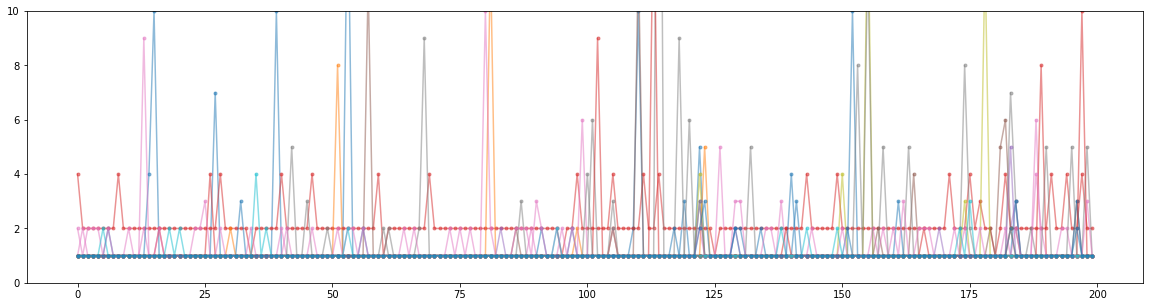

In [8]:
# Let's plot the data using pandas
%matplotlib inline
df.iloc[0:200].plot(style=".-",figsize=(20,5),legend=False, ylim=(0,10), alpha=0.5)

In [66]:
from matplotlib import pyplot as plt
import seaborn as sns

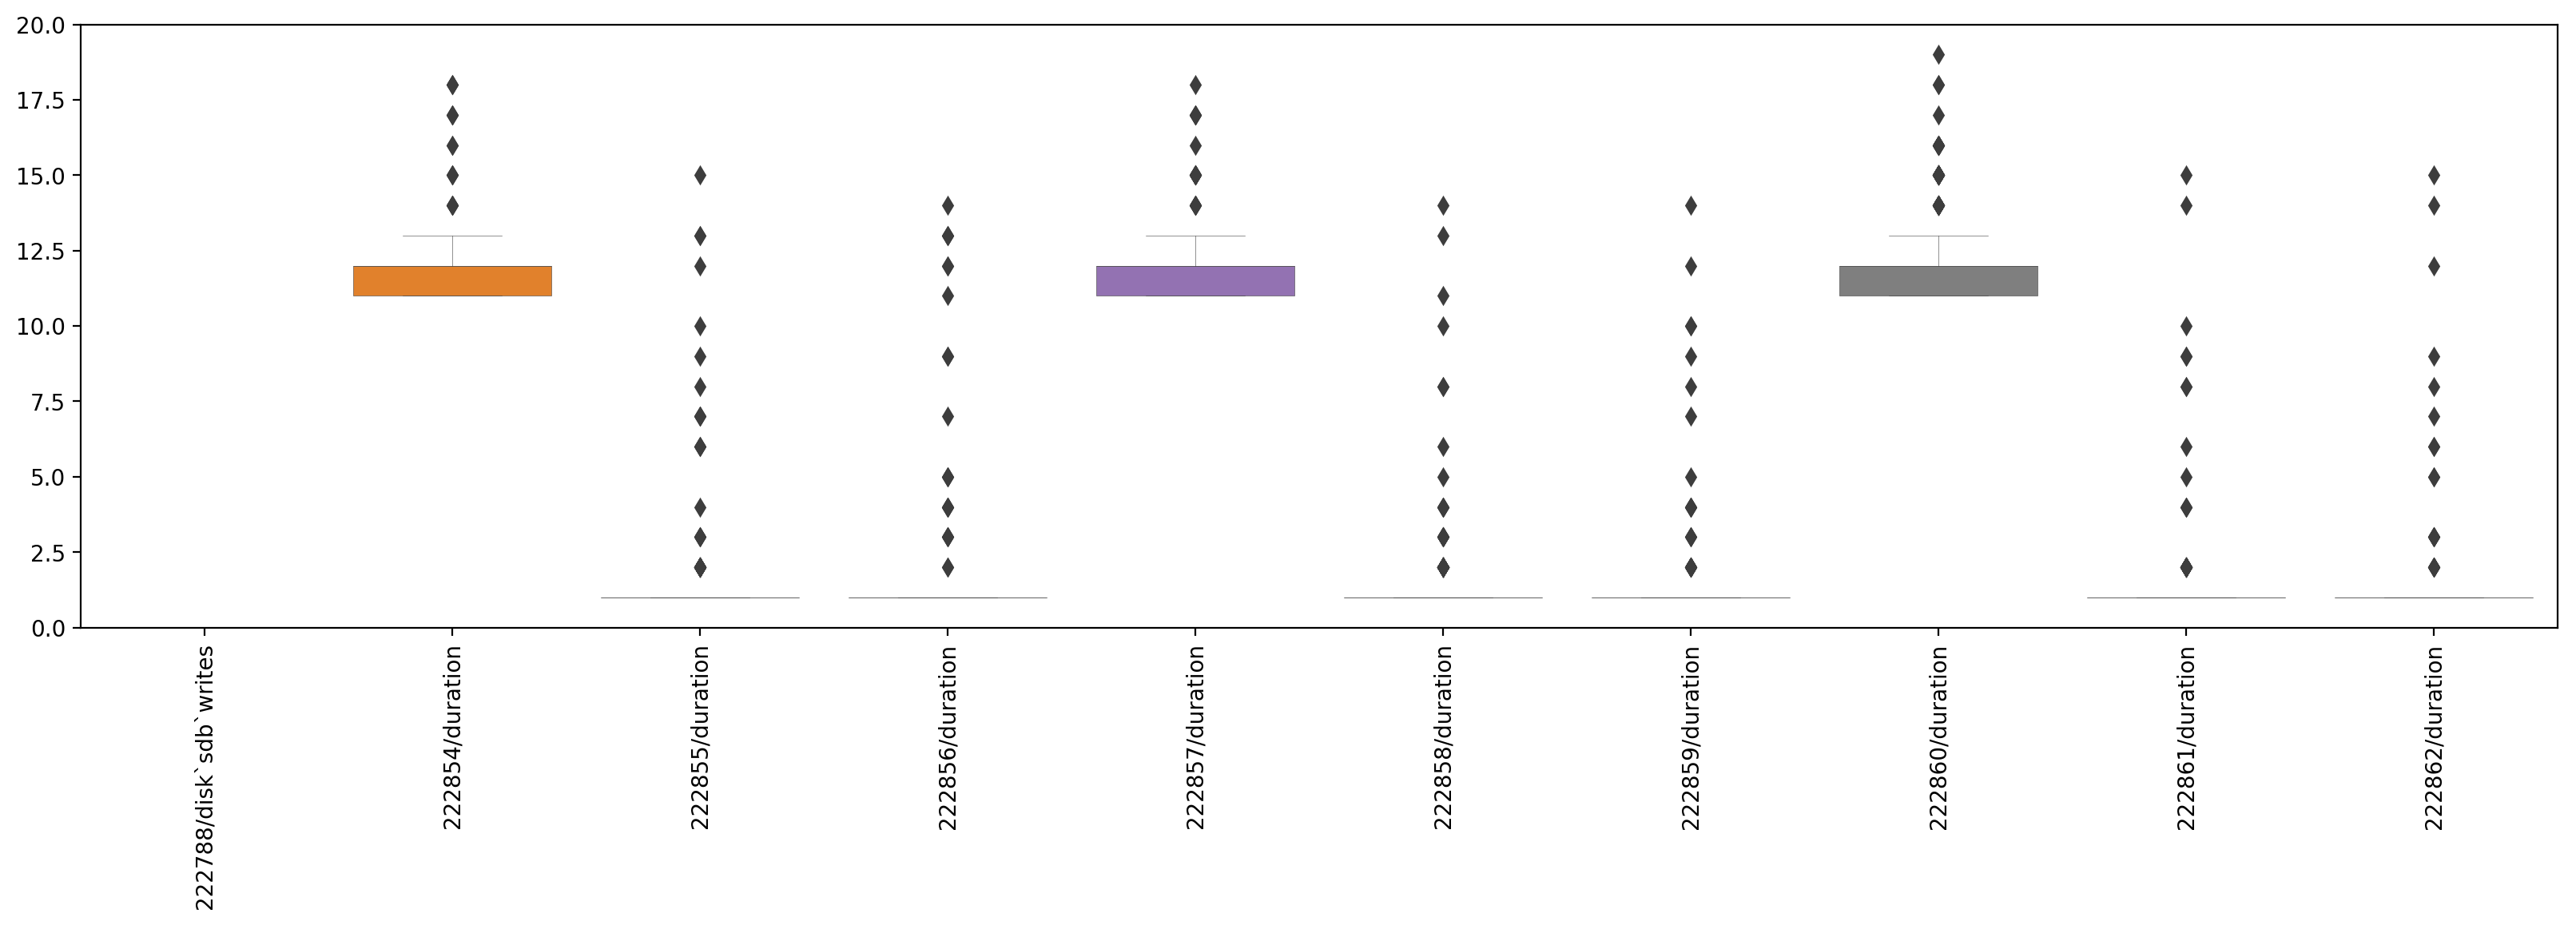

In [111]:
plt.figure(figsize=(20,5),dpi=200)
ax = sns.boxplot(data=df.iloc[:,15:25],linewidth=0.2)
ax.set_ylim(0,20)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

### Working with Histogram Data

Histogram data can be fetched using the kind="histogram" parameter to fetch.
Numeric metrics will be converted to histograms.
Histograms are represented as libcircllhist objects, which have very efficient methods for the most common histogram operations (mean, quantiles).

In [9]:
M = circ.search("api`GET`/getState").fetch(datetime(2018,1,1).timestamp(), 60*60, 7*24, kind="histogram")

In [10]:
# We can directly work with circonus histograms in pandas
dfh = pd.DataFrame(M)
dfh['p99'] = dfh['160764/api`GET`/getState'].map(lambda h: h.quantile(0.99))
dfh['p50'] = dfh['160764/api`GET`/getState'].map(lambda h: h.quantile(0.5))
dfh['mean'] = dfh['160764/api`GET`/getState'].map(lambda h: h.mean())
dfh.head()

,160764/api`GET`/getState,p99,p50,mean
0,"{""+29e-002"": 2, ""+40e-002"": 6, ""+50e-002"": 8, ...",112.835714,11.992790,15.387013
1,"{""+40e-002"": 2, ""+50e-002"": 2, ""+59e-002"": 5, ...",114.961628,16.567822,19.542284
2,"{""+40e-002"": 3, ""+50e-002"": 12, ""+59e-002"": 4,...",118.124324,20.556859,24.012226
3,"{""+29e-002"": 1, ""+40e-002"": 7, ""+50e-002"": 21,...",427.122222,20.827982,37.040173
4,"{""+40e-002"": 6, ""+50e-002"": 26, ""+59e-002"": 15...",496.077778,23.247373,40.965517


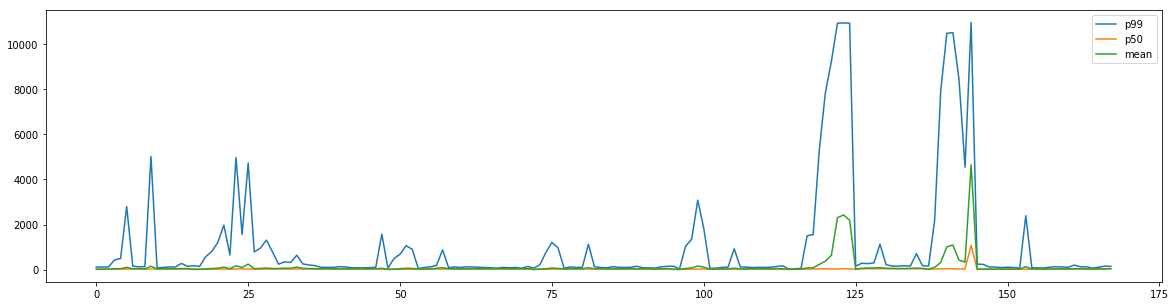

In [11]:
dfh.plot(figsize=(20,5))

## The CAQL API

The Circonus Analytics Query langauge, allows to more efficient data fetching.
Moreover you can apply certain transformation to the data before fetching it.

In [43]:
%time A = circ.caql('search:metric("duration")', datetime(2018,1,1), 60, 5000)
dfa = pd.DataFrame(A)
dfa.head()

CPU times: user 30 ms, sys: 40 ms, total: 70 ms
Wall time: 1.05 s


,output[0],output[10],output[11],output[12],output[13],output[14],output[15],output[16],output[17],output[18],...,output[20],output[21],output[2],output[3],output[4],output[5],output[6],output[7],output[8],output[9]
0,4,12,1,1,2,1,1,1,11,1,...,12,1,1,1,1,1,1,11,12,1
1,2,12,1,1,1,1,1,1,11,1,...,12,1,1,1,1,1,2,12,11,1
2,2,11,1,1,2,1,1,1,12,1,...,12,1,1,1,1,1,1,12,12,1
3,2,12,1,1,2,1,1,1,12,1,...,13,1,1,1,1,1,1,11,12,1
4,2,11,1,1,2,1,1,1,11,1,...,11,1,1,1,1,1,1,11,12,1


That's right we just fetched 1000 samples from 22 metrics in just over 1 second.
The equivalent `circ.search().fetch()` statment would have taken around one minute to complete.

One drawback of the CAQL fetching is, that we use the metric names in the output.
We are working on resolving this shortcoming.

You can also fetch histogram data with `circ.caql()`.
There is no need for an explicit kind argument here, as it is already specified in the query string.

In [44]:
AH = circ.caql('search:metric:histogram("a*")', datetime(2018,1,1), 60*60, 24)
dfah = pd.DataFrame(AH)
dfah.head()

,output[0]
0,"{""+50e-002"": 1, ""+59e-002"": 2, ""+90e-002"": 1, ..."
1,"{""+59e-002"": 1, ""+69e-002"": 2, ""+34e-001"": 2, ..."
2,"{""+50e-002"": 1, ""+69e-002"": 1, ""+80e-002"": 1, ..."
3,"{""+59e-002"": 1, ""+69e-002"": 1, ""+80e-002"": 1, ..."
4,"{""+36e-001"": 1, ""+38e-001"": 5, ""+39e-001"": 11,..."


We can perform a wide variety of data transformation tasks directly inside Circonus using CAQL expressions.
This speeds up the computation even further.
Another advantage is, that we can leverage CAQL queries for live graphing and alerting in the Circonus UI.

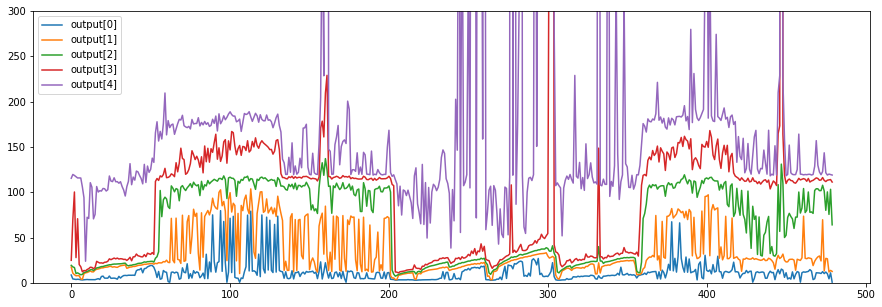

In [124]:
BH = circ.caql('''
search:metric:histogram("a*") | histogram:merge() | histogram:percentile(5,20,50,80,95)
''', datetime(2018,1,1), 60*5, 24*20)
dfbh = pd.DataFrame(BH)
dfbh.plot(figsize=(15,5),ylim=(0,300))